#### Load Data and Inspeact Structure

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the dataset
df = pd.read_csv("C:/Users/hp/OneDrive - menbimarket/Desktop/solar-challenge-week1/data/togo-dapaong_qc.csv", parse_dates=["Timestamp"])

# Quick look at the data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

### Summary Statistics & Missing-Value Report

In [3]:
# Summary statistics
df.describe()

# Missing values count
missing_report = df.isna().sum()
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)

# List columns with more than 5% missing values
threshold = 0.05 * len(df)
high_null_cols = missing_report[missing_report > threshold]
print(high_null_cols)

Comments    525600
dtype: int64


### Outlier Detection & Basic Cleaning

In [4]:
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
z_scores = df[columns_to_check].apply(zscore)

# Flag outliers with |Z| > 3
outliers = (np.abs(z_scores) > 3)

# Optional: Mark or drop outliers
df['is_outlier'] = outliers.any(axis=1)

# Drop rows with high outliers or handle separately
df_cleaned = df[~df['is_outlier']].copy()

# Impute missing values in key columns with median
for col in columns_to_check:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Save cleaned data 
df_cleaned.to_csv("C:/Users/hp/OneDrive - menbimarket/Desktop/solar-challenge-week1/data/Togo_clean.csv", index=False)



#### Time Series Analysis

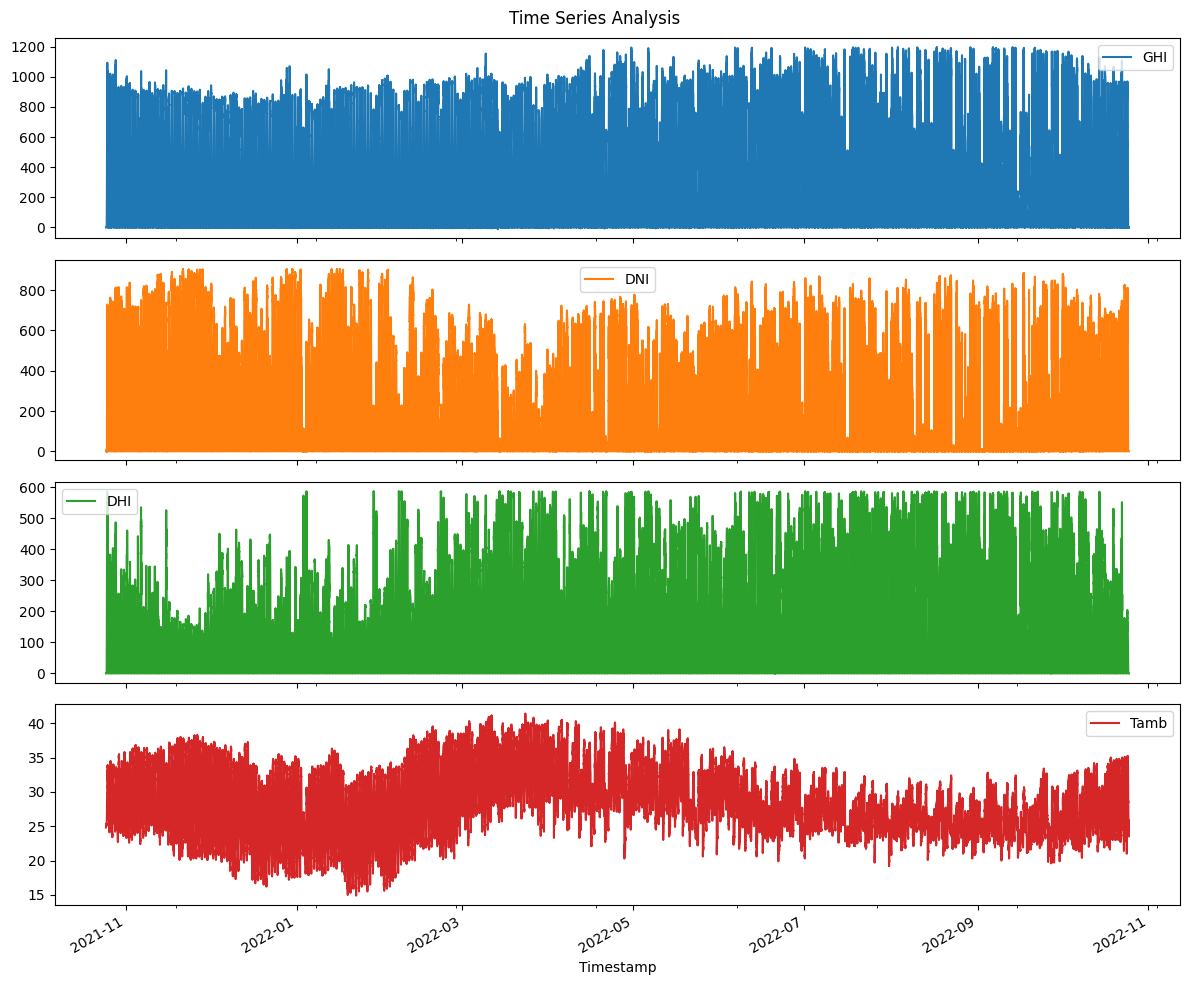

In [5]:
time_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
df_cleaned.set_index('Timestamp')[time_cols].plot(subplots=True, figsize=(12, 10), title="Time Series Analysis")
plt.tight_layout()
plt.show()

In [6]:
df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])
df_cleaned.set_index('Timestamp', inplace=True)

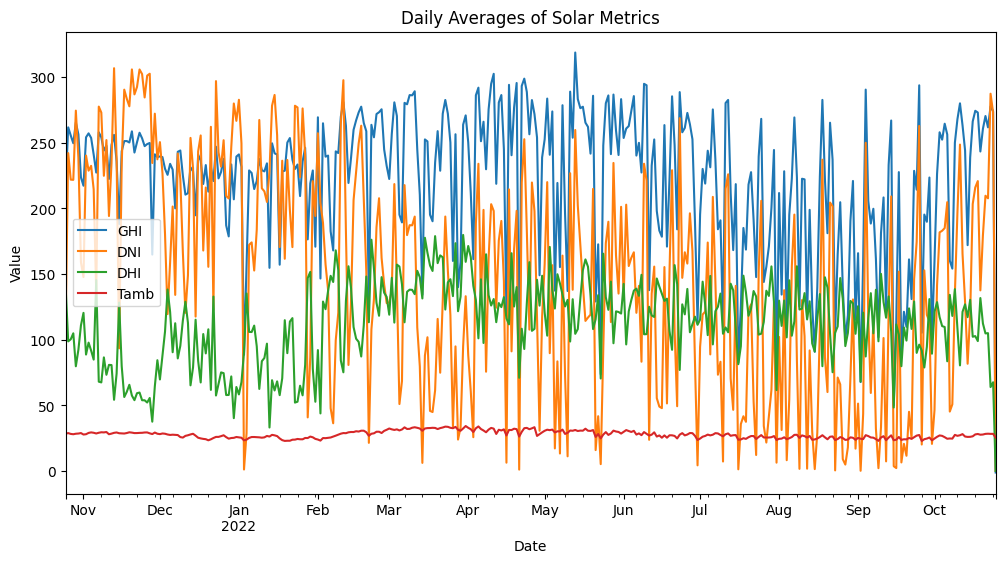

In [7]:
daily_avg = df_cleaned.resample('D').mean()

# Plot
daily_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(12, 6), title='Daily Averages of Solar Metrics')
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_27720\1489615352.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_cleaned.resample('M').mean()


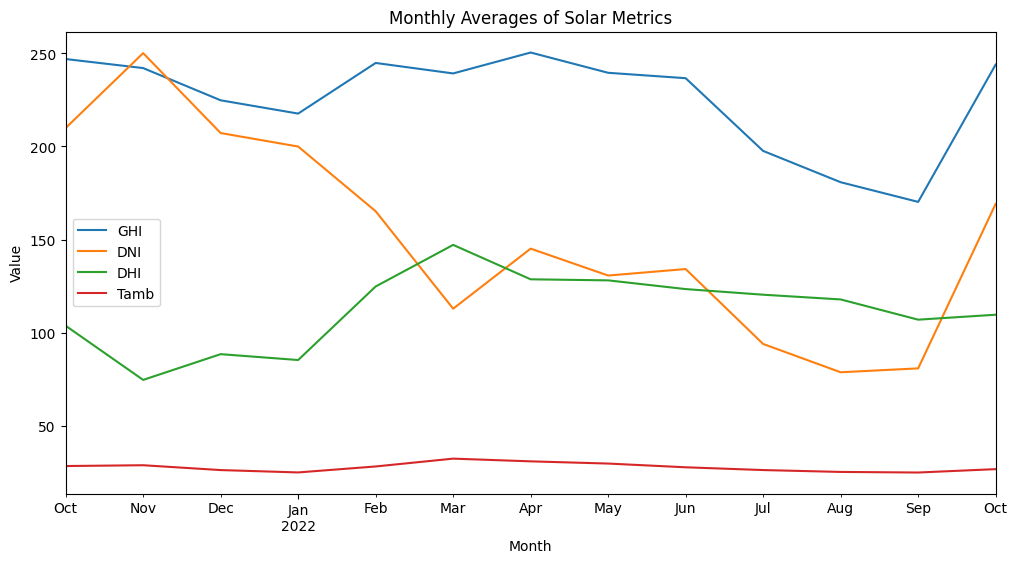

In [8]:
monthly_avg = df_cleaned.resample('M').mean()

monthly_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(12, 6), title='Monthly Averages of Solar Metrics')
plt.ylabel('Value')
plt.xlabel('Month')
plt.show()


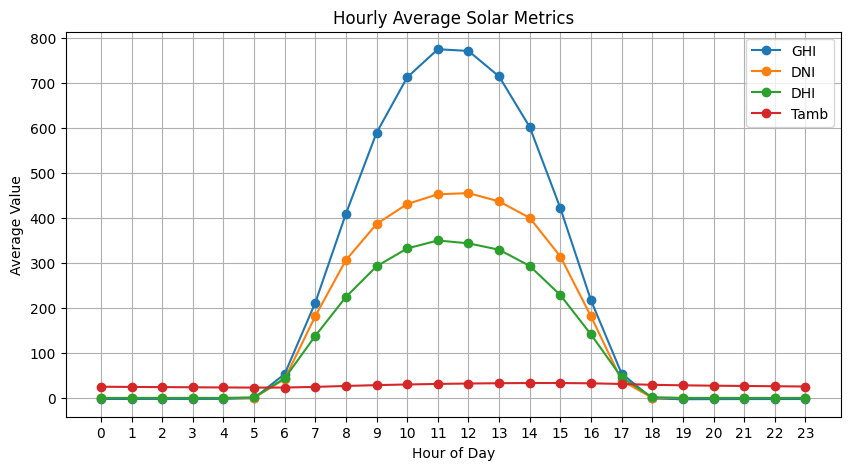

In [9]:
# Extract hour from Timestamp
df_cleaned['hour'] = df_cleaned.index.hour

# Group by hour and get mean
hourly_avg = df_cleaned.groupby('hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Plot
hourly_avg.plot(figsize=(10, 5), marker='o', title='Hourly Average Solar Metrics')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

#### Cleaning Impact Analysis

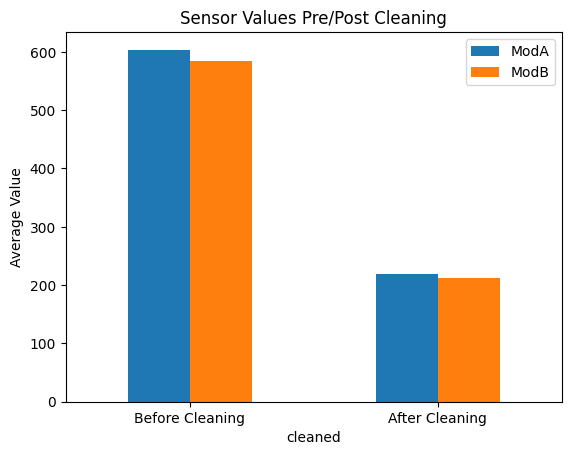

In [10]:
df['cleaned'] = ~df['is_outlier']

# Compare ModA and ModB averages before and after cleaning
df.groupby('cleaned')[['ModA', 'ModB']].mean().plot(kind='bar', title="Sensor Values Pre/Post Cleaning")
plt.xticks(ticks=[0,1], labels=['Before Cleaning', 'After Cleaning'], rotation=0)
plt.ylabel("Average Value")
plt.show()

#### Correlation & Relationship Analysis

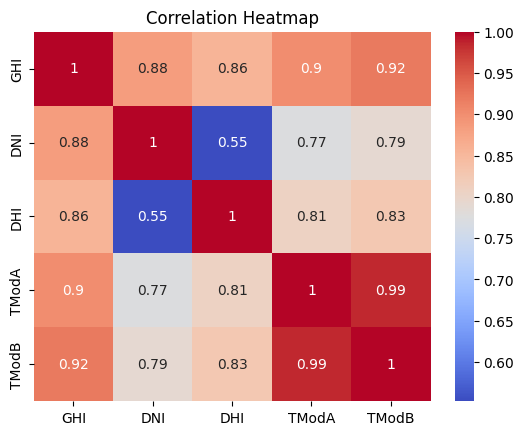

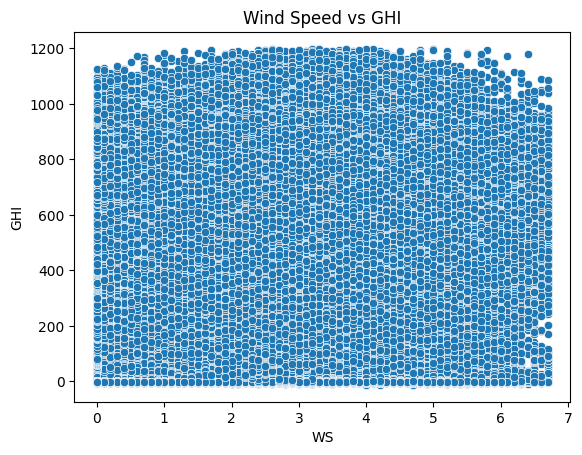

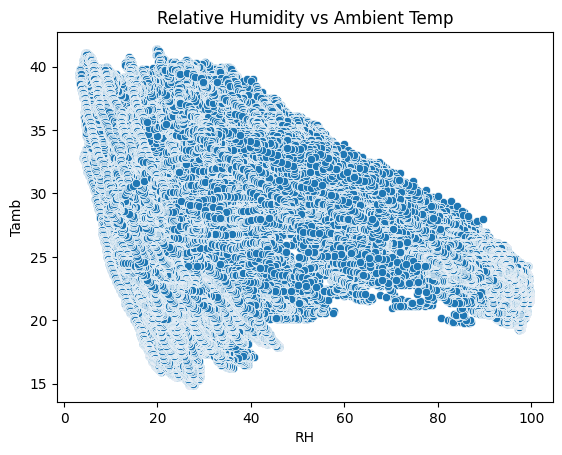

In [11]:
# Correlation heatmap
sns.heatmap(df_cleaned[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
sns.scatterplot(data=df_cleaned, x='WS', y='GHI')
plt.title("Wind Speed vs GHI")
plt.show()

sns.scatterplot(data=df_cleaned, x='RH', y='Tamb')
plt.title("Relative Humidity vs Ambient Temp")
plt.show()


##### Wind & Distribution Analysis

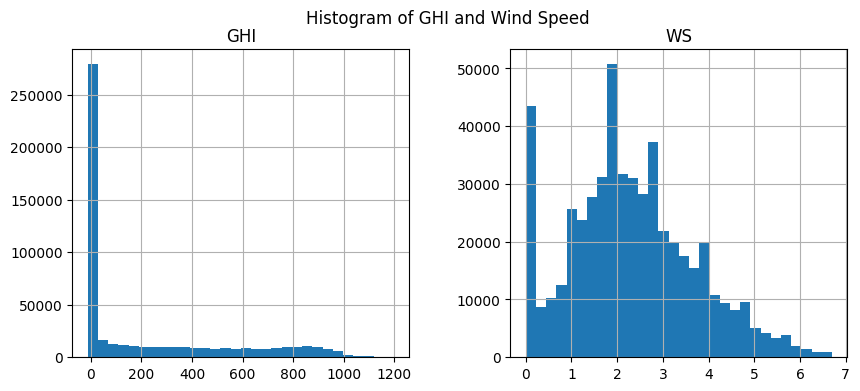

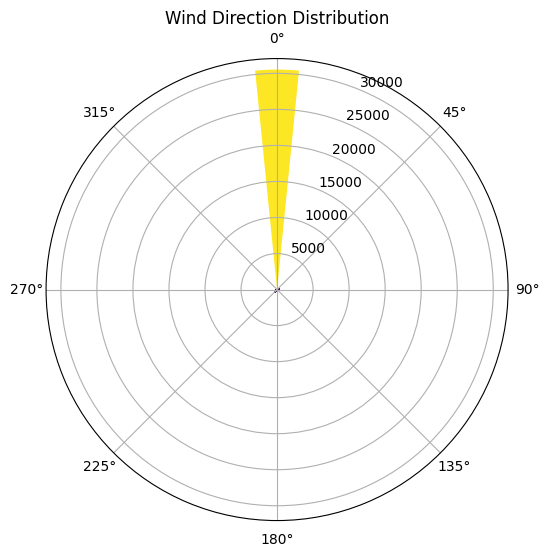

In [12]:
# Histograms
df_cleaned[['GHI', 'WS']].hist(figsize=(10, 4), bins=30)
plt.suptitle("Histogram of GHI and Wind Speed")
plt.show()

# Wind rose needs some extra packages like `windrose` or use polar plots
# Here’s a simplified radial plot using matplotlib
import matplotlib.cm as cm

wd_counts = df_cleaned['WD'].value_counts().sort_index()
angles = np.deg2rad(wd_counts.index)
radii = wd_counts.values
colors = cm.viridis(radii / radii.max())

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.bar(angles, radii, width=0.2, color=colors)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.title("Wind Direction Distribution")
plt.show()

#### Temperature & Humidity Relationship

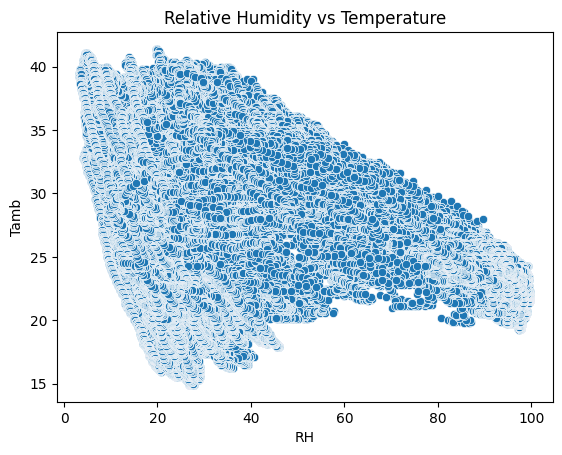

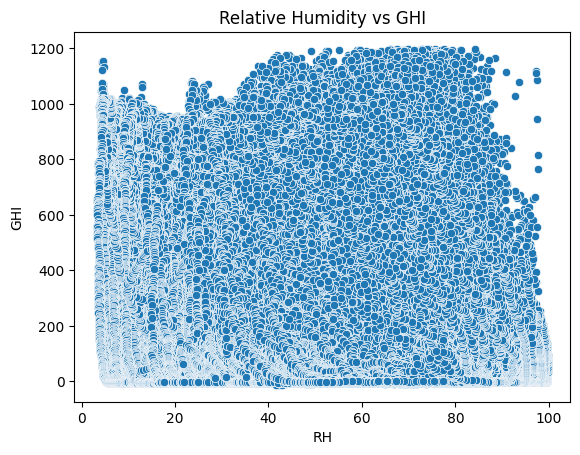

In [13]:
sns.scatterplot(data=df_cleaned, x='RH', y='Tamb')
plt.title("Relative Humidity vs Temperature")
plt.show()

sns.scatterplot(data=df_cleaned, x='RH', y='GHI')
plt.title("Relative Humidity vs GHI")
plt.show()

#### Bubble chart

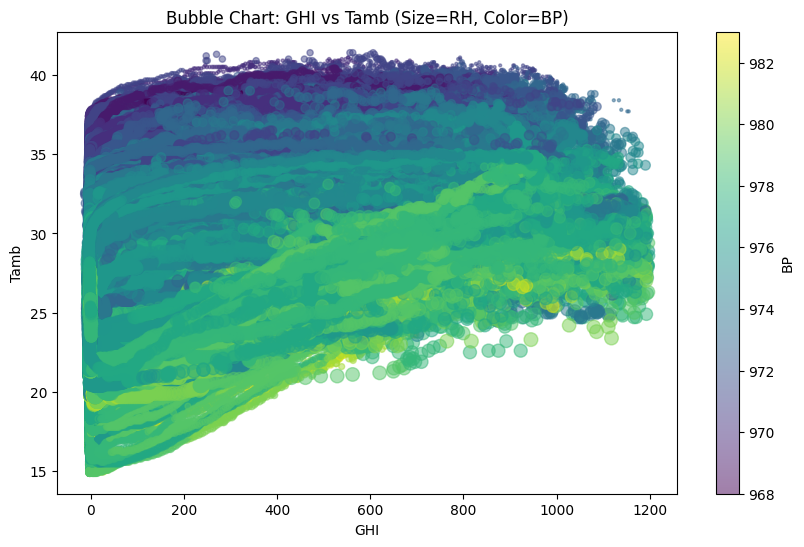

In [14]:
plt.figure(figsize=(10,6))
bubble = plt.scatter(data=df_cleaned, x='GHI', y='Tamb', 
                     s=df_cleaned['RH'], alpha=0.5, c=df_cleaned['BP'], cmap='viridis')
plt.colorbar(label='BP')
plt.title("Bubble Chart: GHI vs Tamb (Size=RH, Color=BP)")
plt.xlabel("GHI")
plt.ylabel("Tamb")
plt.show()
